In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/workspace/phylo_estimation/data_inference')

In [3]:
import pickle
import itertools
import time
import os
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model

from evaluation.classification import generate_class_results, plot_conf_mat, \
                                      get_classification_results, generate_class_results_calibrate_model

# Load data

In [4]:
pickle_path = '/workspace/phylo_estimation/data_inference/pickles/real_rho_test/'
res_path = "/workspace/phylo_estimation/data_inference/models/class/"

n_tips = ['674']

# Classification

In [5]:

results = dict()
results_calibrated_model = dict()

for i in n_tips:
    with open(pickle_path + "dataset_" + i + "_1000_realrho_test.pkl", 'rb') as f:
        data = pickle.load(f)
    
    results[i] = dict()
    results_calibrated_model[i] = dict()
        
    model_path = res_path + i + "_classification_"

    print('---', i, 'tips ---')
    results[i] = generate_class_results(model_path, data['X_test'],
                                        data['y_class_test'])
    results_calibrated_model[i] = generate_class_results_calibrate_model(model_path, data['X_test'],
                                        data['y_class_test'])

--- 674 tips ---
--- Inference time:  2.9711225032806396 seconds ---


/workspace/phylo_estimation/data_inference/evaluation/classification.py:132: RuntimeWarning: overflow encountered in exp
  return np.exp(scaled_prediction) / np.sum(np.exp(scaled_prediction), axis=-1, keepdims=True)
/workspace/phylo_estimation/data_inference/evaluation/classification.py:132: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(scaled_prediction) / np.sum(np.exp(scaled_prediction), axis=-1, keepdims=True)


### No calibrated model 

In [6]:
get_classification_results(results)

,674
accuracy,0.930333
F1-Score,0.929845
Recall,0.930333
Precision,0.930228
Number of params,53110
Train time,873.546248


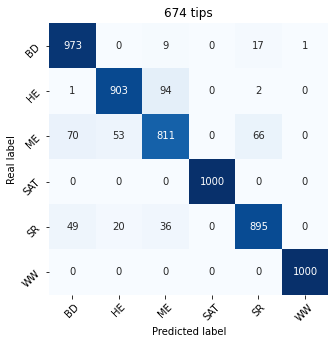

              precision    recall  f1-score   support

           0     0.8902    0.9730    0.9298      1000
           1     0.9252    0.9030    0.9140      1000
           2     0.8537    0.8110    0.8318      1000
           3     1.0000    1.0000    1.0000      1000
           4     0.9133    0.8950    0.9040      1000
           5     0.9990    1.0000    0.9995      1000

    accuracy                         0.9303      6000
   macro avg     0.9302    0.9303    0.9298      6000
weighted avg     0.9302    0.9303    0.9298      6000



In [7]:
label_names = ["BD", "HE", "ME", "SAT", "SR", "WW"]
for i in results:
    plot_conf_mat((results[i]["y_pred"]), (results[i]["y_test"]), label_names, i)

### Calibrated model 

In [8]:
get_classification_results(results_calibrated_model)

,674
accuracy,0.923667
F1-Score,0.923356
Recall,0.923667
Precision,0.924233
Number of params,53110
Train time,963.543995


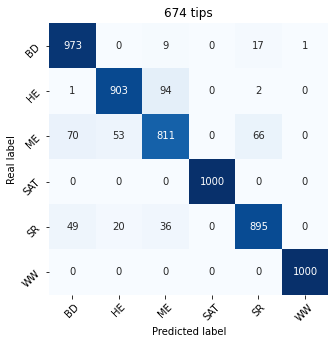

              precision    recall  f1-score   support

           0     0.8902    0.9730    0.9298      1000
           1     0.9252    0.9030    0.9140      1000
           2     0.8537    0.8110    0.8318      1000
           3     1.0000    1.0000    1.0000      1000
           4     0.9133    0.8950    0.9040      1000
           5     0.9990    1.0000    0.9995      1000

    accuracy                         0.9303      6000
   macro avg     0.9302    0.9303    0.9298      6000
weighted avg     0.9302    0.9303    0.9298      6000



In [9]:
label_names = ["BD", "HE", "ME", "SAT", "SR", "WW"]
for i in results_calibrated_model:
    plot_conf_mat((results[i]["y_pred"]), (results[i]["y_test"]), label_names, i)

# Regression

In [10]:
pd.options.display.float_format = "{:,.4f}".format

In [11]:
with open(pickle_path + "dataset_" + "674" + "_1000_realrho_test.pkl", 'rb') as f:
    data = pickle.load(f)
res_path = "/workspace/phylo_estimation/data_inference/models/reg/"

In [12]:
mae_dict = dict()
inf_times = dict()

    
for label in np.unique(data['div_info_test']):
    print(label)
    div_scenario = label.split('/')[1].split('_')[0]
    mae_dict[div_scenario] = dict()
    print(div_scenario)
    
    inf_times[div_scenario] = dict()
    
    norm_types = ['norm', 'no_norm']
    for norm in norm_types:
        mae_dict[div_scenario][norm] = dict()
        inf_times[div_scenario][norm] = dict()
        
        # Load regression model 
        model_path = res_path + div_scenario + '/' + "674" + "_regression_"
        if norm != 'no_norm':
            model_path += norm + '_'
        
        nn_model = load_model(model_path + 'model.keras')
    
    
    
    
        pred = nn_model.predict(np.expand_dims(data['X_test'][data['div_info_test'] == label], axis=2))
         
        
        
        if norm == 'norm':
            norm_text = '_norm'
        else:
            norm_text = ''
        y_reg_test = data['y_reg' + norm_text + '_test'][data['div_info_test'] == label]
        y_reg_test = [np.array(elem) for elem in y_reg_test]
        
        real = y_reg_test
        error = abs(pred-real)
        
        resc_factor_test = data['resc_factor_test'][data['div_info_test'] == label]
        
        if norm == 'norm':
            mae_dict[div_scenario][norm]['mae_rescaled'] = np.mean(error, axis=0)
            
            
            if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
                
                pred[:, 0] = pred[:, 0] / resc_factor_test

            elif div_scenario == "ME":
                
                pred[:, 0] = pred[:, 0] / resc_factor_test
                pred[:, 2] = pred[:, 2] / resc_factor_test

            else:
    
                pred[:, 0] = pred[:, 0] / resc_factor_test
                pred[:, 1] = pred[:, 1] / resc_factor_test
                pred[:, 4] = pred[:, 4] / resc_factor_test
                
            y_reg_test = data['y_reg_test'][data['div_info_test'] == label]
            y_reg_test = [np.array(elem) for elem in y_reg_test]
            
            real = y_reg_test
            error = abs(pred-real)
            
            mae_dict[div_scenario][norm]['mae'] = np.mean(error, axis=0)
            
        else: 
        
            mae_dict[div_scenario][norm]['mae'] = np.mean(error, axis=0)
            
            if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
                
                pred[:, 0] = pred[:, 0] * resc_factor_test

            elif div_scenario == "ME":
                pred[:, 0] = pred[:, 0] * resc_factor_test
                pred[:, 2] = pred[:, 2] * resc_factor_test

            else:
                
                pred[:, 0] = pred[:, 0] * resc_factor_test
                pred[:, 1] = pred[:, 1] * resc_factor_test
                pred[:, 4] = pred[:, 4] * resc_factor_test
                
            
            y_reg_test = data['y_reg_norm_test'][data['div_info_test'] == label]
            y_reg_test = [np.array(elem) for elem in y_reg_test]
            
            real = y_reg_test
            error = abs(pred-real)                
        
            mae_dict[div_scenario][norm]['mae_rescaled'] = np.mean(error, axis=0)     

674_1000_realrho_test/BD_sim_no_fossil1000_rescale.csv
BD
674_1000_realrho_test/HE_sim_no_fossil1000_rescale.csv
HE
674_1000_realrho_test/ME_rho_PGP_sim_no_fossil1000_rescale.csv
ME
674_1000_realrho_test/SAT_sim_no_fossil1000_rescale.csv
SAT
674_1000_realrho_test/SR_sim_no_fossil1000_rescale.csv
SR
674_1000_realrho_test/WW_sim_no_fossil1000_rescale.csv
WW


In [13]:
def get_regression_div_results(results, scenario, norm, error):
    reg_values = {
        'BD': ['r', 'a'],
        'HE': ['r', 'a'],
        'ME': ['r', 'a', 'time', 'frac'],
        'SR': ['r0', 'r1', 'a0', 'a1', 'time'],
        'WW': ['r0', 'r1', 'a0', 'a1', 'time'],
        'SAT': ['lambda 0'],
    }

    # Extraemos la lista de valores
    values = results[scenario][norm][error]

    # Comprobamos tamaño
    if len(values) != len(reg_values[scenario]):
        raise ValueError(f"Dimensiones no coinciden: {len(values)} valores vs {len(reg_values[scenario])} parámetros.")

    # Creamos un DataFrame de una sola fila
    df = pd.DataFrame([values], columns=reg_values[scenario], index=['MAE'])

    return df

In [14]:
labels = ['BD', 'HE', 'ME', 'SAT', 'SR', 'WW']
for label in labels: 
    print(label)
    data = get_regression_div_results(mae_dict, label, 'norm', 'mae')
    print(data)

BD
         r      a
MAE 0.1321 0.1119
HE
         r      a
MAE 0.2071 0.0215
ME
         r      a   time   frac
MAE 0.0342 0.0794 5.0498 0.0497
SAT
     lambda 0
MAE    0.0610
SR
        r0     r1     a0     a1   time
MAE 0.0742 0.0224 0.1097 0.0965 3.7160
WW
        r0     r1     a0     a1   time
MAE 0.0349 0.1033 0.1690 0.0856 2.8707
